![arc-logo](admin/image/arc-logo.png)
# Projet P3
## HeadlinesMachineLearningModel
Ce notebook retrace les différentes étapes de création des modèles de machines learning avec le jeu de données des titres d'articles financiers

`Auteur` : Romain Capocasale (INF3dlm-a)

`Superviseur` : Hatem Ghorbel

`Date` : 24.01.2020

# 1. Importation

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import sys
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from gensim.sklearn_api import D2VTransformer
from gensim.utils import simple_preprocess
from joblib import dump, load
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.svm import SVR, SVC
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.manifold import TSNE
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

from tools.TextProcessor import TextProcessor

np.random.seed(42)# to make this notebook's output stable across runs

# 2. Chragement du jeu de données

In [2]:
dataset = pd.read_json('dataset/headlines_dataset/financialData.json')

# 3. Analyse du jeu de données

In [3]:
dataset.head()

,title,sentiment
0,watching for bounce tomorrow,0.366
1,record number of passengers served in 2015,0.638
2,out $NFLX -.35,-0.494
3,Looking for a strong bounce Lunchtime rally co...,0.460
4,Very intrigued with the technology and growth ...,0.403


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2866 entries, 0 to 2865
Data columns (total 2 columns):
title        2866 non-null object
sentiment    2866 non-null float64
dtypes: float64(1), object(1)
memory usage: 44.9+ KB


In [5]:
dataset.describe()

,sentiment
count,2866.000000
mean,0.079841
std,0.391033
min,-1.000000
25%,-0.285000
50%,0.206000
75%,0.387000
max,1.000000


Le jeu de données contient 2 colonnes :
    - sentiment : le sentiment de la pharse, entre -1 pour negatif et 1 pour positif
    - title : le titre de l'article financier

## 3.1 Répartition des classes

In [6]:
nb_pos, nb_neg, nb_ntr = len([sent for sent in dataset.sentiment if sent > 0]), len([sent for sent in dataset.sentiment if sent < 0]), len([sent for sent in dataset.sentiment if sent == 0])
tot = len(dataset)
print("Number of data : {}".format(tot))
print("Number of positive data : {} ({}%)".format(nb_pos, round( nb_pos/tot*100, 3)))
print("Number of negative data : {} ({}%)".format(nb_neg, round( nb_neg/tot*100, 3)))
print("Number of neutral data : {} ({}%)".format(nb_ntr, round( nb_ntr/tot*100, 3)))
print("Ratio positive/negative : {}".format(round(nb_pos/nb_neg, 3)))

Number of data : 2866
Number of positive data : 1756 (61.27%)
Number of negative data : 1045 (36.462%)
Number of neutral data : 65 (2.268%)
Ratio positive/negative : 1.68


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000167DB0CB948>]],
      dtype=object)

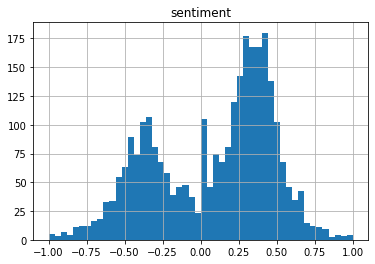

In [7]:
dataset.hist(bins=50)

On remarque qu'il y a plus de phrase avec un sentiment positif que négatif. On remarque également sur le graphe 2 pics, un pour les sentiments négatifs aux alentours de -0.40 et un pour les sentiment positif vers 0.40.

## 3.2 Nombre de mot moyen par phrase

In [8]:
def average_word_by_sentence(sentences):
    '''Compute the average of word in a sentence
    sentence -- list of sentences
    return -- average number of word by sentence
    '''
    nb_total_word = 0
    for row in sentences:
        nb_total_word += len(row.split())
    return round(nb_total_word / len(sentences), 3)

In [9]:
print("Average of word by sentence : {}".format(average_word_by_sentence(dataset['title'])) )

Average of word by sentence : 7.515


Text(0, 0.5, 'Number of sentence')

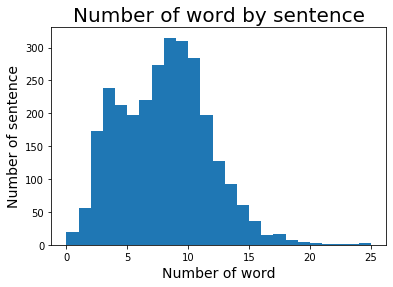

In [10]:
num_word_by_sentence = [len(x.split()) for x in dataset['title']]#count the number of word for each sentences

plt.hist(num_word_by_sentence, bins=25)
plt.title('Number of word by sentence', fontsize=20)
plt.xlabel('Number of word', fontsize=14)
plt.ylabel('Number of sentence', fontsize=14)

On remarque que la moyenne de nombre de mot par phrase est de **7.515** et on peut voir sur le graphe la répartition du nombre de mot par phrase.

# 4. Séparation des observation et des étiquettes

In [11]:
X = dataset['title']
y = dataset['sentiment']

## 4.1 Séparation du jeu d'entrainement et jeu de test 
Le jeu d'entrainement est séparé en 2 parties, La première partie est le jeu d'entrainement qui sera utilisé pour la création du modèle d'analyse de sentiment. Le jeu de test sera lui utilisé pour tester la qualité des modèles évalués.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# 5. Definition des méthode de calcul de score
La méthode print_scores() permet de calculer la RMSE, la MAE, l'éxactitude, la précision et le rappel à partir des vraies étiquettes et des étiquettes prédites. Il est également possible d'indiquer le seuil désiré, le seuil permet de definir pour une prédiction si elle doit considéré come positive ou négative. La méthode regression_score_to_classification() permet de transformer les étiquettes du format régression au format classification. Les étiquettes de -1 à seuil sont mise à 0 et celles de seuil à 1 sont mise à 1.

In [13]:
def regression_score_to_classification(labels, threshold):
    '''Set to 0 regression prediction between -1 and thresold, set to 1 regression preiction between thresold and 1
    Allow to pass from regression prediction to classification prediction
    
    labels -- list of regression score
    thresold -- thresold
    
    return -- list of labels either 0 or 1
    '''
    
    y_clf = []
    for i, y in enumerate(labels):
        if y <= threshold:
            y_clf.append(0)
        elif y > threshold:
            y_clf.append(1)
    return np.array(y_clf)
        

def print_scores(name, y_test, y_pred, threshold=0, show_classification_report=False):
    '''Display the RMSE, MAE and accuracy for a model
    
    name -- name of the model
    y_test -- true data
    y_pred -- predicted data 
    threshold=0 -- threshold
    show_classification_report=False -- display the score with sklearn.metrics.classification_report function
    
    '''
    print("RMSE for {} : {}".format(name, np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
    print("MAE for {} : {}".format(name, metrics.mean_absolute_error(y_test, y_pred)))
    
    y_test_clf = regression_score_to_classification(y_test, threshold)
    y_pred_clf = regression_score_to_classification(y_pred, threshold)
    
    print("Accuracy for {} : {}".format(name, metrics.accuracy_score(y_test_clf, y_pred_clf)))
    print("Recall for {} : {}".format(name, metrics.recall_score(y_test_clf, y_pred_clf)))
    print("Precision for {} : {}".format(name, metrics.precision_score(y_test_clf, y_pred_clf)))
    if show_classification_report:
        print(metrics.classification_report(y_test_clf, y_pred_clf))

# 6. Score de textblob et VADER
Nous allons comparé le score de l'analyseur de sentiment de VADER(nltk) et textblob sur le jeu d'entrainement. Les scores obtenus ici seront utilisé comme score de référence pour l'évaluation des futures modèles. Le but des futures modèles est de battre ces scores.

In [14]:
y_pred_textblob = []

for x in X_test:
    blob_analyser = TextBlob(x)
    y_pred_textblob.append(blob_analyser.polarity)
    
y_pred_textblob = np.array(y_pred_textblob)
print_scores('textblob', y_test, y_pred_textblob)

RMSE for textblob : 0.39409590123479016
MAE for textblob : 0.3344453600193542
Accuracy for textblob : 0.5174216027874564
Recall for textblob : 0.31843575418994413
Precision for textblob : 0.7755102040816326


In [15]:
vader_analyser = SentimentIntensityAnalyzer()

y_pred_vader = []
for x in X_test:
    y_pred_vader.append(vader_analyser.polarity_scores(x)['compound'])

y_pred_vader = np.array(y_pred_vader)
print_scores('VADER', y_test, y_pred_vader)

RMSE for VADER : 0.41008217369349853
MAE for VADER : 0.33125731707317074
Accuracy for VADER : 0.5487804878048781
Recall for VADER : 0.39106145251396646
Precision for VADER : 0.7734806629834254


On remarque ques ces analyseurs ont une RMSE et MAE assez haute. L'exactitude est à peine au dessus de 50% et le compromis précison/rappel n'est pas bon. De plus, on remarque que ces 2 analyseurs ont souvent tendances à prédire une polarité de zéro pour les phrases. *364* zeros pour textblob et *282* pour Vader. 


# 7. Traitement du texte
## 7.1. Prétraitement avec Spacy

Le traitement du texte est effectué avec la librairie Spacy. La classe de prétraitement du texte se trouve dans : ``tools/TextProcessor``. La classe hérite de BaseEstimator et de TransformerMixin. Le fait d'heriter de ces 2 classes permettera d'inclure cette classe dans le pipeline sklearn. Différent paramétres pour le prétraitement du texte sont défini dans le constructeur. Le principale avantage de cette méthode est qu'elle se combine avec l'utilisation de la classe GridSearchCV() ou RandomSearch() qui permet de chercher les meilleurs hyper-parametrès pour un modèle.

Pour le prétraitement, différentes processus sont effectués sur la phrase:
 * **Tokenisation** : consiste à découper la phrase en mot.
 * **Suppression des ``stop word``** : suppresion des mots comme ``the``, ``are``, etc. Ce paramétre est configurable via le constructeur
 * **Tagging et suppression de certains mots tagués** : le tagging consiste à detecter le type du mot comme par exemple ``nom``, ``adjectif``, ``verbe``, etc. Par la suite, il faut supprimer le type de mot que l'on ne veut pas garder dans la phrase. Actuellement, les verbes, adverbes, nom et adjectifs sont conservés. Ce paramétre est configurable via le constructeur.
 * **Taille du mot** : consiste à garder que les mots d'une certaines taille. Ce paramétre est configurable via le constructeur.
 * **Suppresion de la ponctuation** : suppresion des caractère comme ``!``, ``?``, etc.
 * **Lemmatisation** : consiste à ne garder que la racine des mots dans le but de réduire la taille du dictionnaire. Par exemple, les mots comme ``runs``, ``running`` seront transformer en ``run``.

In [16]:
tp = TextProcessor(keep_only_good_word=False, remove_stop_word=True)
X_train_pre_spacy = tp.transform(X_train)
X_test_pre_spacy = tp.transform(X_test)

## 7.2 Prétraitement avec Gensim
Utilisation de la méthode simple_preprocess, pour utiliser le prétraitement de Gensim dans les modèles il faut remplacer les varaibles ``X_train_pre_spacy`` et ``X_test_pre_spacy`` par ``X_train_pre_gen`` et ``X_test_pre_gen``. 

In [6]:
X_train_pre_spacy = [' '.join(simple_preprocess(sentence)) for sentence in X_train ]
X_test_pre_spacy = [' '.join(simple_preprocess(sentence)) for sentence in X_test ]

# 8. Modèle de machine learning avec TFidf

## 8.1 Création des pipelines et entrainement des modeles
Un pipeline est créé pour chaque type de modèle. Trois types de modèles ont été selectionné : 

* la régression linéaire
* la machine à vecteur de support 
* la Foret aléatoire

La classe TfidfVectorizer permet de calculer le score tfidf pour une phrase donné.

In [17]:
lr_model = Pipeline([('tfidf', TfidfVectorizer()),
                    ('lr', LinearRegression(n_jobs=-1))])

svr_model = Pipeline([('tfidf', TfidfVectorizer()),('svr', SVR(kernel='poly'))])

rfr_model = Pipeline([('tfidf', TfidfVectorizer()),
                    ('rfr', RandomForestRegressor(n_jobs=-1))])

lr_model.fit(X_train_pre_spacy, y_train)
print("lr_model is done")
svr_model.fit(X_train_pre_spacy, y_train)
print("svr_model is done")
rfr_model.fit(X_train_pre_spacy, y_train)
print("rfr_model is done")

lr_model is done


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


svr_model is done


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


rfr_model is done


## 8.2 Evaluation des modèles
Le score des modèles est calculé avec le jeu de test. On remarque que pour la MAE et la RMSE seul le modèle Random Forest Regressor obtient de meilleurs résultats que les analyseurs preccedents. On peut également constater que la Random Forest Regressor obtient une bonne précison et un bon rappel.

In [18]:
y_pred_lr = lr_model.predict(X_test_pre_spacy)
print_scores('Linear regression', y_test, y_pred_lr)
print("\n")
y_pred_svr = svr_model.predict(X_test_pre_spacy)
print_scores('Support Vector Regression', y_test, y_pred_svr)
print("\n")
y_pred_rfr = rfr_model.predict(X_test_pre_spacy)
print_scores('Random forest regressor', y_test, y_pred_rfr, -0.10)

RMSE for Linear regression : 0.5863239103350047
MAE for Linear regression : 0.39035970502206513
Accuracy for Linear regression : 0.7229965156794426
Recall for Linear regression : 0.7458100558659218
Precision for Linear regression : 0.7970149253731343


RMSE for Support Vector Regression : 0.39891491103449844
MAE for Support Vector Regression : 0.32363240415397093
Accuracy for Support Vector Regression : 0.6236933797909407
Recall for Support Vector Regression : 1.0
Precision for Support Vector Regression : 0.6236933797909407


RMSE for Random forest regressor : 0.28867546200058297
MAE for Random forest regressor : 0.2050416997282776
Accuracy for Random forest regressor : 0.8031358885017421
Recall for Random forest regressor : 0.8701298701298701
Precision for Random forest regressor : 0.8417085427135679


# 8.3 Recherche aléatoire
En plus d'optimiser les paramètres du modèle, la recherche alétoire entraine les modèles avec dans ce cas 5 folds. Ce qui va permettre de s'assurer que le modèle n'overfit pas trop. La recherche aléatoire va effectuer 50 itérations

In [20]:
param_grid_random = {
    'tfidf__use_idf' : (True, False),
    'rfr__n_estimators' : [30, 100, 200, 400, 1000, 1200, 1500],
    'rfr__max_features' : [2,4,6,8, 20, 100],
    'rfr__bootstrap' : (True, False),
    'rfr__max_depth' : [10, 30 , 50, 80, 100, None],
    'rfr__min_samples_leaf': [1, 2, 4],
    'rfr__min_samples_split': [2, 5, 10]
}

rfr_model_random = Pipeline([('tfidf', TfidfVectorizer()),
                    ('rfr', RandomForestRegressor())])

random_search_rfr = RandomizedSearchCV(rfr_model_random, param_grid_random,scoring='neg_mean_absolute_error', n_iter=50, verbose=1, cv=5, n_jobs=-1)
random_search_rfr.fit(X_train_pre_spacy, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  3.6min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('tfidf',
                                              TfidfVectorizer(analyzer='word',
                                                              binary=False,
                                                              decode_error='strict',
                                                              dtype=<class 'numpy.float64'>,
                                                              encoding='utf-8',
                                                              input='content',
                                                              lowercase=True,
                                                              max_df=1.0,
                                                              max_features=None,
                                                              min_df=1,
                                       

### 8.3.1 Meilleurs paramètres de la recherche aléatoire

In [21]:
random_search_rfr.best_params_

{'tfidf__use_idf': True,
 'rfr__n_estimators': 200,
 'rfr__min_samples_split': 5,
 'rfr__min_samples_leaf': 1,
 'rfr__max_features': 20,
 'rfr__max_depth': None,
 'rfr__bootstrap': False}

### 8.3.2 Evaluation de la recherche aléatoire
On constate qu'on obtient de meilleure résultats avec la recherche aléatoire.

In [22]:
y_pred_rfr_random = random_search_rfr.predict(X_test_pre_spacy)
print_scores('Random forest regressor - random search', y_test, y_pred_rfr_random, -0.14)

RMSE for Random forest regressor - random search : 0.27747611656946797
MAE for Random forest regressor - random search : 0.194404381097561
Accuracy for Random forest regressor - random search : 0.8222996515679443
Recall for Random forest regressor - random search : 0.923469387755102
Precision for Random forest regressor - random search : 0.8341013824884793


## 8.4 Sauvegarde du modèle

In [23]:
dump(random_search_rfr, 'saved_model/headlines_dataset_tfidf.joblib')

['saved_model/headlines_dataset_tfidf.joblib']

# 9. Modèle de machine learning avec d2v de Gensim

## 9.1 Prétraitement du texte
Pour envoyer les phrases au doc2vec il faut qu les mots sois placé dans une liste. On réeffectue le préprocessing sur le textes mais cette fois on met d'une phrases dans une liste.

### 9.1.2 Spacy
Le paramètre ``is_word_joined`` renvoie une liste de de liste(qui représente les mots de la phrase) au lieu d'une liste de string(qui représente la phrase).

In [24]:
tp_list = TextProcessor(is_word_joined=False, keep_only_good_word=False, remove_stop_word=True)
X_train_pre_list_spacy = tp_list.fit_transform(X_train)
X_test_pre_list_spacy = tp_list.fit_transform(X_test)

### 9.1.2 Gensim
Utilisation de la méthode simple_preprocess, pour utiliser le prétraitement de Gensim dans les modèles il faut remplacer les varaibles ``X_train_pre_list_spacy`` et ``X_test_pre_list_spacy`` par ``X_train_pre_list_gen`` et ``X_test_pre_list_gen``.

In [25]:
X_train_pre_list_gen = []
for sentence in X_train:
    X_train_pre_list_gen.append(simple_preprocess(sentence))
    
X_test_pre_list_gen = []
for sentence in X_test:
    X_test_pre_list_gen.append(simple_preprocess(sentence))

## 9.2 Création du doc2vec

In [26]:
doc2Vec_model =  D2VTransformer()
doc2Vec_model.fit(X_train_pre_list_spacy+X_test_pre_list_spacy)

D2VTransformer(alpha=0.025, batch_words=10000, cbow_mean=1, comment=None,
               dbow_words=0, dm=1, dm_concat=0, dm_mean=None, dm_tag_count=1,
               docvecs=None, docvecs_mapfile=None,
               hashfxn=<built-in function hash>, hs=0, iter=5,
               max_vocab_size=None, min_alpha=0.0001, min_count=5, negative=5,
               sample=0.001, seed=1, size=100, sorted_vocab=1, trim_rule=None,
               window=5, workers=3)

In [27]:
X_train_pre_d2v = doc2Vec_model.transform(X_train_pre_list_spacy)
X_test_pre_d2v = doc2Vec_model.transform(X_test_pre_list_spacy)

Les phrases sont transformées en vecteurs.

## 9.3 Création des pipelines et entrainement des modèles

In [28]:
rfr_model_d2v = RandomForestRegressor(n_estimators=200, max_features=50)
rfr_model_d2v.fit(X_train_pre_d2v, y_train)

lr_model_d2v = LinearRegression()
lr_model_d2v.fit(X_train_pre_d2v, y_train)

svr_model_d2v = SVR(kernel='poly')
svr_model_d2v.fit(X_train_pre_d2v, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='poly', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [29]:
rfr_pipeline_d2v = Pipeline([('d2v', doc2Vec_model),
                     ('rfr', rfr_model_d2v)])

lr_pipeline_d2v = Pipeline([('d2v', doc2Vec_model),
                     ('rfr', lr_model_d2v)])

svr_pipeline_d2v = Pipeline([('d2v', doc2Vec_model),
                    ('svr', svr_model_d2v)])

## 9.4 Évaluation des modèles
Ces modèles ont en moyenne de moins bon résultats que les modèles préceddent. On remarque qu'en moyenne le rappel à augmenter sur tout les modèles et la précision diminué.

In [30]:
y_pred_rfr_d2v = rfr_pipeline_d2v.predict(X_test_pre_list_spacy)
print_scores('Random forest regressor', y_test, y_pred_rfr_d2v)
print("\n")
y_pred_lr_d2v = lr_pipeline_d2v.predict(X_test_pre_list_spacy)
print_scores('Linear regression', y_test, y_pred_lr_d2v)
print("\n")
y_pred_svr_d2v = svr_pipeline_d2v.predict(X_test_pre_list_spacy)
print_scores('Support Vector Regression', y_test, y_pred_svr_d2v)

RMSE for Random forest regressor : 0.34772342763211384
MAE for Random forest regressor : 0.2774085828132694
Accuracy for Random forest regressor : 0.6742160278745645
Recall for Random forest regressor : 0.9078212290502793
Precision for Random forest regressor : 0.6784968684759917


RMSE for Linear regression : 0.3954054418637158
MAE for Linear regression : 0.33590432258760267
Accuracy for Linear regression : 0.5818815331010453
Recall for Linear regression : 0.770949720670391
Precision for Linear regression : 0.6359447004608295


RMSE for Support Vector Regression : 0.39891491106723087
MAE for Support Vector Regression : 0.3236324041811843
Accuracy for Support Vector Regression : 0.6236933797909407
Recall for Support Vector Regression : 1.0
Precision for Support Vector Regression : 0.6236933797909407


## 9.5 Entrainement du modèle avec la validation croisé

In [31]:
scores = cross_val_score(rfr_model_d2v, X_train_pre_d2v, y_train, scoring="neg_mean_absolute_error", cv=5, n_jobs=-1)
print(-scores)

[0.28425973 0.28161583 0.29432584 0.28066612 0.29301899]


## 9.6 Représentation T-sne 
Le T-sne permet de représenter les phrases du doc2vec dans l'espace. On constate que les phrases sont assez éparpillé et que les phrases postives ne sont pas regroupé avec les positives et inversement.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2866 samples in 0.022s...
[t-SNE] Computed neighbors for 2866 samples in 1.370s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2866
[t-SNE] Computed conditional probabilities for sample 2000 / 2866
[t-SNE] Computed conditional probabilities for sample 2866 / 2866
[t-SNE] Mean sigma: 0.008546
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.311966
[t-SNE] KL divergence after 1000 iterations: 2.832433


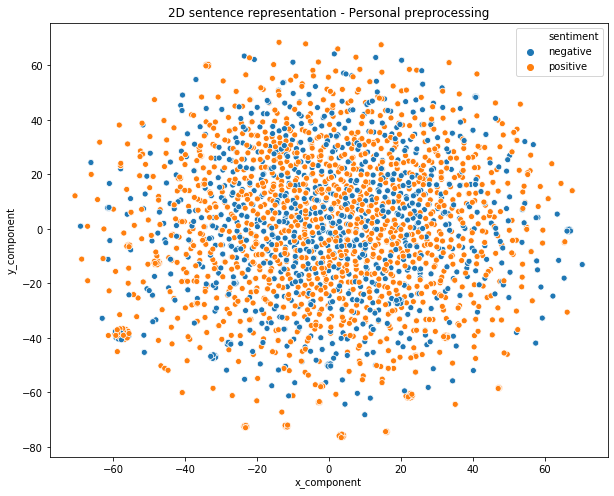

In [32]:
tsne = TSNE(n_components=2, random_state=0, verbose=1)
X_2d_gen = tsne.fit_transform(np.concatenate((X_train_pre_d2v, X_test_pre_d2v), axis=0))

X_component_gen = [item[0] for item in X_2d_gen]
Y_component_gen = [item[1] for item in X_2d_gen]

sent = ["positive" if sent>= 0 else "negative" for sent in (y_train.tolist() + y_test.tolist())]

df_scatter_gen = pd.DataFrame({'x_component':X_component_gen, 'y_component':Y_component_gen, 'sentiment':sent})
plt.figure(figsize=(10,8))
plt.title("2D sentence representation - Personal preprocessing")
ax = sns.scatterplot(x='x_component', y='y_component', hue='sentiment', data=df_scatter_gen)

## 9.6 Sauvegarde du modèle

In [33]:
dump(rfr_pipeline_d2v, 'saved_model/headlines_dataset_w2v.joblib')

['saved_model/headlines_dataset_w2v.joblib']

# 10. word2vec financier 
## 10.1 Importation du word2vec financier

In [19]:
sys.path.insert(0, 'word2vec/financialWord2vec/src')
from financial_corpus import FinancialCorpus
from financial_w2vec import FinancialWord2Vec

financial_w2vec = pickle.load(open('word2vec/financialWord2vec/data/models_pickle/FinancialWord2Vec.pkl','rb'))
w2vec_model = financial_w2vec.model
financial_corpus = financial_w2vec.financial_corpus

bigram_mod = financial_corpus.bigram_mod
trigram_mod = financial_corpus.bigram_mod

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\romain.capocasa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 10.2 Nombres de mot présent dans le word2vec
Cette cellule ne fonctionne que si le prétraitement du texte à été effectué avec Spacy et non gensim.

In [20]:
nb_word_in_w2v = 0
for w in tp.vocab:
    if w in w2vec_model.wv.vocab:
        nb_word_in_w2v+=1
print("There are {} words in the word2vec on {} ".format(nb_word_in_w2v, len(tp.vocab)))

There are 2082 words in the word2vec on 4149 


## 10.3 Longeur maximum d'une phrase
La longeur maximum nous permettera d'effectuer la technique du padding pour les vecteurs

In [21]:
max_sentence_length = 0
for sentence in dataset['title']:
    sentence_length = len(sentence.split())
    if sentence_length > max_sentence_length:
        max_sentence_length = sentence_length
print("The maximum word in a sentence is : {}".format(max_sentence_length))

The maximum word in a sentence is : 25


## 10.4 Calcul du Tf-idf
Le score TF-idf est calculé sur le jeu de donnée et les scores sont exporté dans un dictionnaire avec comme clé le mot et comme valeur le score TF-idf de ce mot.

In [22]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(X_train_pre_spacy+X_test_pre_spacy)

feature_names = tfidf.get_feature_names()
word2tfidf = dict(zip(feature_names, tfidf.idf_))

## 10.5 Définition des fonctions
Definitions des différentes fonctions permettant de représenter une phrase dans l'espace.

In [23]:
def get_tfidf_score(word):
    '''Return the TF-idf score for a word. If the word is not in the dict return 0.
    
    word -- a word of a sentence
    
    return -- the TF-idf score for this word
    '''
    if word in word2tfidf:
        return word2tfidf[word]
    else:
        return 0.0

In [24]:
def get_w2v_from_word(word, dimension=100):
    '''Return the word2vec vector for the given word. 
    If the word is not in the word2vec vocab return a fille vector of 0 the size of the dimension
    
    word -- a word of a sentence
    dimension -- the dimension of the vector
    
    return -- The word2vec vector
    '''
    if word in w2vec_model.wv.vocab: 
        doc = trigram_mod[bigram_mod[[word]]]
        return w2vec_model.wv[doc][0]
    else :
        return np.zeros(dimension)

In [25]:
def sentences_to_w2v_big_vector(sentences, mode, dimension=100):
    '''Transforms the list of passed sentences into a vector representation. The vectors here are concatenate.
    For exemple : if the maximum sentence size is 25 and the dimension is 100. The number of vector component will be 2500.
    
    sentences -- list of preprocessed sentences
    mode -- type of vectorial representation, 'concat' => concatene all the word vector in sequence,'concat_tfidf' => concatene the word vector and multiply by the tf-idf score of the word, 
    dimension -- the dimension of the vector

    return -- the list of sentences in the space
    '''
    sentences_w2v = []
    for sentence in sentences:  
        
        vectors = np.asarray([])
        splited_sentence = sentence.split()
        for i in range(0, max_sentence_length):
            try :
                word = splited_sentence[i]
                w2v_word = get_w2v_from_word(word)
                
                if mode=="concat_tfidf":
                    tfidf_score = get_tfidf_score(word)
                    vectors = np.append(vectors, w2v_word*tfidf_score)
                elif mode=="concat":
                    vectors = np.append(vectors, w2v_word)
                
            except IndexError:
                vectors = np.append(vectors, np.zeros(dimension))
                
        sentences_w2v.append(vectors)
    return sentences_w2v

In [26]:
def sentences_to_w2v_small_vector(sentences, mode, dimension=100):
    '''Transforms the list of passed sentences into a vector representation. The vector is summed.
    For exemple : if the maximum sentence size is 25 and the dimension is 100. The number of vector component will be 100.
    
    sentences - list of preprocessed sentences
    mode -- type of vectorial representation, 'sum' => sum all the vector, 'sum_tfidf' => sum the vector and multiply each vector by tf_idf score, 'avg' => sum all the vector and divide by the sentence length, 'avg' => sum the vector, multiply each vector by tf_idf score and divide by sentence length
    dimension -- the dimension of the vector
    
    return the list of sentences in the space
    '''
    sentences_w2v = []    
    for sentence in sentences:
        vectors = np.zeros(100)
        
        splited_sentence = sentence.split()
        for word in splited_sentence:
            w2v_word = get_w2v_from_word(word)
            
            if mode=="sum_tfidf" or mode=="avg_tfidf":
                tfidf_score=get_tfidf_score(word)
                vectors = np.add(vectors, w2v_word*tfidf_score)
            elif mode=="sum" or mode=="avg":              
                vectors = np.add(vectors, w2v_word)
        
        if mode=="avg_tfidf" or mode=="avg":    
            if len(splited_sentence) != 0:
                sentences_w2v.append(vectors/len(splited_sentence))
            else :
                sentences_w2v.append(np.zeros(dimension))
        elif mode=="sum" or mode=="sum_tfidf":
            sentences_w2v.append(vectors)
    return np.asarray(sentences_w2v)

## 10.6 Représentation des phrases dans l'espace

In [27]:
X_train_pre_w2v = sentences_to_w2v_small_vector(X_train_pre_spacy, mode="avg")
X_test_pre_w2v = sentences_to_w2v_small_vector(X_test_pre_spacy, mode="avg")

## 10.7 Entrainement des modèles

In [28]:
rfr_model_w2v = RandomForestRegressor(n_estimators=100, max_features=50)
rfr_model_w2v.fit(X_train_pre_w2v, y_train)
print("training finish for rfr")

lr_model_w2v = LinearRegression()
lr_model_w2v.fit(X_train_pre_w2v, y_train)
print("training finish for lr")

svr_model_w2v = SVR(kernel='poly')
svr_model_w2v.fit(X_train_pre_w2v, y_train)
print("training finish for svr")

training finish for rfr
training finish for lr


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


training finish for svr


## 10.8 Calcul des scores
Cette fois si la précison et le rappel sont meilleure qu'avec gensim.

In [29]:
y_pred_rfr_w2v = rfr_model_w2v.predict(X_test_pre_w2v)
print_scores('Random forest regressor', y_test, y_pred_rfr_w2v)
print("\n")
y_pred_lr_w2v = lr_model_w2v.predict(X_test_pre_w2v)
print_scores('Linear regression', y_test, y_pred_lr_w2v)
print("\n")
y_pred_svr_w2v = svr_model_w2v.predict(X_test_pre_w2v)
print_scores('Support Vector Regression', y_test, y_pred_svr_w2v)

RMSE for Random forest regressor : 0.31908018322597737
MAE for Random forest regressor : 0.24681341644180135
Accuracy for Random forest regressor : 0.7560975609756098
Recall for Random forest regressor : 0.8770949720670391
Precision for Random forest regressor : 0.7658536585365854


RMSE for Linear regression : 0.3387019255006186
MAE for Linear regression : 0.27764543717593954
Accuracy for Linear regression : 0.7508710801393729
Recall for Linear regression : 0.8379888268156425
Precision for Linear regression : 0.7792207792207793


RMSE for Support Vector Regression : 0.36014613967523057
MAE for Support Vector Regression : 0.269443533279749
Accuracy for Support Vector Regression : 0.7473867595818815
Recall for Support Vector Regression : 0.9217877094972067
Precision for Support Vector Regression : 0.738255033557047


## 10.9 Entrainement du modèle avec la validation croisé
Au vu des scores MAE on voit que le moèdle n'overfit pas trop. La MAE est similaire à celle calculé préceddement

In [47]:
scores = cross_val_score(rfr_model_w2v, X_train_pre_w2v, y_train, scoring="neg_mean_absolute_error", cv=5, n_jobs=-1)
print(-scores)

[0.25593582 0.24959695 0.26041473 0.25683354 0.26167178]


## 10.10 Représentation T-sne

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2866 samples in 0.018s...
[t-SNE] Computed neighbors for 2866 samples in 1.366s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2866
[t-SNE] Computed conditional probabilities for sample 2000 / 2866
[t-SNE] Computed conditional probabilities for sample 2866 / 2866
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.827591
[t-SNE] KL divergence after 1000 iterations: 1.565812


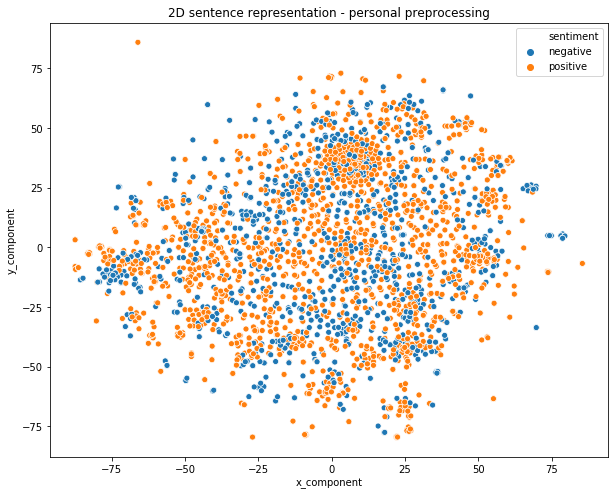

In [48]:
tsne = TSNE(n_components=2, random_state=0, verbose=1)
X_2d_financial = tsne.fit_transform(np.concatenate((X_train_pre_w2v, X_test_pre_w2v), axis=0))

X_component_financial = [item[0] for item in X_2d_financial]
Y_component_financial = [item[1] for item in X_2d_financial]

sent = ["positive" if sent>= 0 else "negative" for sent in (y_train.tolist() + y_test.tolist())]

df_scatter_financial = pd.DataFrame({'x_component':X_component_financial, 'y_component':Y_component_financial, 'sentiment':sent})
plt.figure(figsize=(10,8))
plt.title("2D sentence representation - personal preprocessing")
ax = sns.scatterplot(x='x_component', y='y_component', hue='sentiment', data=df_scatter_financial)

# 11. Classificateur

## 11.1 Titres d'articles financiers sur un mois
Pour exécuter les modèles avec les titres d'articles financiers sur un mois il faut exécuter cette cellule. Je récupére les textes et les sentiments correspondants dans 2 fichiers séparés et je les ajoute dans un dataset.

In [ ]:
headlines_mon = []
f_headlines = open('dataset/monthly_headlines/headlines.txt', 'r', encoding='utf-8')
for h in f_headlines.read().splitlines():
    headlines_mon.append(str(h))
f_headlines.close()

sentiments_mon = []
f_sentiments = open('dataset/monthly_headlines/sentiments.txt', 'r', encoding='utf-8')
for s in f_sentiments.read().splitlines():
    sentiments_mon.append(int(s))
f_sentiments.close()

dataset = pd.DataFrame(list(zip(headlines, sentiments)), columns =['title', 'sentiment'])

Entrainons maintenant uniquement des classificateurs. On commence par supprimer les phrases qui ont un sentiment compris entre -0.1 et 0.1 car ces phrases sont trop proches de 0 pour être classifié comme positive ou négative.

In [39]:
index_to_remove = []
for i, e in dataset.iterrows():
    if e['sentiment'] < 0.1 and e['sentiment'] > -0.1:
        index_to_remove.append(i)
classification_data = dataset.drop(index_to_remove)
print("size of data : {}".format(len(classification_data)))

size of data : 13160


## 11.2 Séparation des observations et étiquettes
Les sentiments en dessous de 0 sont transformé en 0 et ceux en dessus de 0 en 1.

In [40]:
X_classification = classification_data['title']
y_classfication = np.array([1 if s > 0 else 0 for s in classification_data['sentiment']])
X_train_classification, X_test_classification, y_train_classfication, y_test_classification = train_test_split(X_classification, y_classfication, test_size=0.20, random_state=42)

## 11.3 Entrainement des modèles
Les phrases sont converti en chiffre à l'aide de la technique du Tf-Idf.

In [41]:
nb_model = Pipeline([('tfidf', TfidfVectorizer()),
                    ('nb', MultinomialNB())])

svc_model = Pipeline([('tfidf', TfidfVectorizer()),
                     ('svc', SVC())])

dtc_model = Pipeline([('tfidf', TfidfVectorizer()),
                     ('dtc', DecisionTreeClassifier())])

logr_model = Pipeline([('tfidf', TfidfVectorizer()),
                    ('lr', LogisticRegression())])

nb_model.fit(X_train_classification, y_train_classfication)
svc_model.fit(X_train_classification, y_train_classfication)
dtc_model.fit(X_train_classification, y_train_classfication)
logr_model.fit(X_train_classification, y_train_classfication)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=

## 11.4 Evaluation des modèles
Execpté pour le DecisionTreeClassfifier on voit que le rappel est trop haut par rapport à la précision. Il faudrait donc ajuster le seuil pour diminuer le rappel et augmenter la précision. On constate cepandant que les modèles ont quand même un bon score d'exactitude.

In [48]:
y_pred_nb = nb_model.predict(X_test_classification)
print("Accuracy for Naive Bayes : {}".format(metrics.accuracy_score(y_test_classification, y_pred_nb)))
print("Precision for Naive Bayes : {}".format(metrics.precision_score(y_test_classification, y_pred_nb)))
print("Recall for Naive Bayes : {}".format(metrics.recall_score(y_test_classification, y_pred_nb)))
print("\n")

y_pred_svc = svc_model.predict(X_test_classification)
print("Accuracy for SVC : {}".format(metrics.accuracy_score(y_test_classification, y_pred_svc)))
print("Precision for naive SVC : {}".format(metrics.precision_score(y_test_classification, y_pred_svc)))
print("Recall for SVC : {}".format(metrics.recall_score(y_test_classification, y_pred_svc)))
print("\n")

y_pred_dtc = dtc_model.predict(X_test_classification)
print("Accuracy for Decision Tree Classifier : {}".format(metrics.accuracy_score(y_test_classification, y_pred_dtc)))
print("Precision for Decision Tree Classifier : {}".format(metrics.precision_score(y_test_classification, y_pred_dtc)))
print("Recall for Decision Tree Classifier : {}".format(metrics.recall_score(y_test_classification, y_pred_dtc)))
print("\n")

y_pred_logr = logr_model.predict(X_test_classification)
print("Accuracy for Logistic Regression : {}".format(metrics.accuracy_score(y_test_classification, y_pred_logr)))
print("Precision for Logistic Regression : {}".format(metrics.precision_score(y_test_classification, y_pred_logr)))
print("Recall for Decision Logistic Regression : {}".format(metrics.recall_score(y_test_classification, y_pred_logr)))
print("\n")

Accuracy for Naive Bayes : 0.8624620060790273
Precision for Naive Bayes : 0.8665207877461707
Recall for Naive Bayes : 0.9306698002350177


Accuracy for SVC : 0.6466565349544073
Precision for naive SVC : 0.6466565349544073
Recall for SVC : 1.0


Accuracy for Decision Tree Classifier : 0.8457446808510638
Precision for Decision Tree Classifier : 0.8707093821510298
Recall for Decision Tree Classifier : 0.8942420681551116


Accuracy for Logistic Regression : 0.8666413373860182
Precision for Logistic Regression : 0.8512740509620385
Recall for Decision Logistic Regression : 0.9618096357226792




# 12. Tests des modèles sur les Headlines de PPI
On importe les données. On supprime la date et on converti les données textuelles en chiffre. Les phrase avec une polarité de 0 sont supprimé car les classificateurs entrainé sont binaires.

In [49]:
ppi_headlines = pd.read_excel("dataset/ppi_headlines/200_headlines_polarity.xlsx")

In [50]:
del ppi_headlines['Date']

In [51]:
neutral_index = []
for index, row in ppi_headlines.iterrows():
    if row["Polarisation"] == "positif":
        ppi_headlines.iloc[index]["Polarisation"] = 1
    elif row["Polarisation"] == "négatif":
        ppi_headlines.iloc[index]["Polarisation"] = 0
    elif row["Polarisation"] == "neutre":
        neutral_index.append(index)

In [52]:
ppi_headlines = ppi_headlines.drop(neutral_index)

## 12.1 Prétraitement des headlines de PPI
Pour le modèle utilisant le word2vec on doit représenter les phrases dans l'espace

In [53]:
tp_ppi = TextProcessor(keep_only_good_word=False, remove_stop_word=True)
ppi_pre = tp_ppi.fit_transform(ppi_headlines['Headline'])
ppi_pre_vectors = sentences_to_w2v_small_vector(ppi_pre, mode="avg")

## 12.2 Prédiction

In [54]:
y_pred_ppi_rfr = rfr_model.predict(ppi_pre)
y_pred_ppi_dtc = dtc_model.predict(ppi_pre)
y_pred_ppi_logr = logr_model.predict(ppi_pre)
y_pred_ppi_rfr_w2v = rfr_model_w2v.predict(ppi_pre_vectors)

### 12.2.1 Transformation des scores de régression en classification

In [28]:
y_pred_ppi_rfr = regression_score_to_classification(y_pred_ppi_rfr, 0.125)# Il faut régler le seuil à 0.125 pour que le score augmenter
y_pred_ppi_rfr_w2v = regression_score_to_classification(y_pred_ppi_rfr_w2v,0)

## 12.3 Récupération du sentiment

In [55]:
y_test_ppi = ppi_headlines["Polarisation"].to_list()

## 12.4 Calcul des scores de TextBlob et Vader

In [63]:
y_pred_textblob = []

for x in ppi_headlines['Headline']:
    blob_analyser = TextBlob(x)
    y_pred_textblob.append(blob_analyser.polarity)
    
y_pred_textblob = np.array(y_pred_textblob)
print_scores('textblob', y_test_ppi, y_pred_textblob)

RMSE for textblob : 0.6674040265063733
MAE for textblob : 0.49703965741279166
Accuracy for textblob : 0.5298507462686567
Recall for textblob : 0.34375
Precision for textblob : 0.5116279069767442


In [64]:
vader_analyser = SentimentIntensityAnalyzer()

y_pred_vader = []
for x in ppi_headlines['Headline']:
    y_pred_vader.append(vader_analyser.polarity_scores(x)['compound'])

y_pred_vader = np.array(y_pred_vader)
print_scores('VADER', y_test_ppi, y_pred_vader)

RMSE for VADER : 0.708513342231043
MAE for VADER : 0.5363701492537314
Accuracy for VADER : 0.6268656716417911
Recall for VADER : 0.453125
Precision for VADER : 0.6590909090909091


## 12.5 Caclul des scores des modèles personalisés
On constate qu'avec ces nouvelles données les scores ne sont vrm pas bon. On voit que le meilleur modèle à une précision d'a peine plus de 60 %. Ce qui veut dire que les modèles effectue presque des prédictions au hasard.

**Attention si cette celulle est exécuté avec les titres d'articles fianciers pour un mois il faut commenter les 8 premières lignes de la celulle. En effet aucun modèle de régression n'as été developpé avec ces données.**

In [58]:
print("Accuracy for Random Forest Regressor Tf-Idf : {}".format(metrics.accuracy_score(y_test_ppi, y_pred_ppi_rfr)))
print("Precision for Random Forest Regressor Tf-Idf : {}".format(metrics.precision_score(y_test_ppi, y_pred_ppi_rfr)))
print("Recall for Random Forest Regressor Tf-Idf : {}".format(metrics.recall_score(y_test_ppi, y_pred_ppi_rfr)))
print("\n")
print("Accuracy for Random Forest Regressor w2v : {}".format(metrics.accuracy_score(y_test_ppi, y_pred_ppi_rfr_w2v)))
print("Precision for Random Forest Regressor w2v : {}".format(metrics.precision_score(y_test_ppi, y_pred_ppi_rfr_w2v)))
print("Recall for Random Forest Regressor w2v : {}".format(metrics.recall_score(y_test_ppi, y_pred_ppi_rfr_w2v)))
print("\n")
print("Accuracy for Decision Tree Classifier Tf-Idf : {}".format(metrics.accuracy_score(y_test_ppi, y_pred_ppi_dtc)))
print("Precision for Decision Tree Classifier Tf-Idf : {}".format(metrics.precision_score(y_test_ppi, y_pred_ppi_dtc)))
print("Recall for Decision Tree Classifier Tf-Idf : {}".format(metrics.recall_score(y_test_ppi, y_pred_ppi_dtc)))
print("\n")
print("Accuracy for Logistic Regression Tf-Idf : {}".format(metrics.accuracy_score(y_test_ppi, y_pred_ppi_logr)))
print("Precision for Logistic Regression Tf-Idf : {}".format(metrics.precision_score(y_test_ppi, y_pred_ppi_logr)))
print("Recall for Logistic Regression Tf-Idf : {}".format(metrics.recall_score(y_test_ppi, y_pred_ppi_logr)))

Accuracy for Decision Tree Classifier Tf-Idf : 0.5223880597014925
Precision for Decision Tree Classifier Tf-Idf : 0.5
Recall for Decision Tree Classifier Tf-Idf : 0.546875


Accuracy for Logistic Regression Tf-Idf : 0.5373134328358209
Precision for Logistic Regression Tf-Idf : 0.5138888888888888
Recall for Logistic Regression Tf-Idf : 0.578125




'\nprint("Accuracy for Random Forest Regressor w2v : {}".format(metrics.accuracy_score(y_test_ppi, y_pred_ppi_rfr_w2v)))\nprint("Precision for Random Forest Regressor w2v : {}".format(metrics.precision_score(y_test_ppi, y_pred_ppi_rfr_w2v)))\nprint("Recall for Random Forest Regressor w2v : {}".format(metrics.recall_score(y_test_ppi, y_pred_ppi_rfr_w2v)))'

## 12.6 Explications des résultats
Cette cellule ne fonctionne que si le prétraitement des phrases à été effectué avec Spacy.

In [66]:
print("Length of Headlines vocabulary : {}".format(len(tp.vocab)))
print("Length of Annoted Headlines vocabulary : {}".format(len(tp_ppi.vocab)))
print("Number of words present in the 2 datasets vocabulary : {}".format(len(tp.vocab.intersection(tp_ppi.vocab))))

Length of Headlines vocabulary : 4149
Length of Annoted Headlines vocabulary : 667
Number of words present in the 2 datasets vocabulary : 334


On constate que seulement la moitié des headlines de PPi sont présent dans notre jeu de données inital. Les modèles se trouveront confronter à de nombreux mots qu'il ne connaisse pas. Les scores Tf-Idf, certain vecteur de mot, etc ne pourront pas être calcul et seront alors représenté par leur valeur par défaut. Ceci peut expliquer les mauvais scores obtenus. Vader et Textblob obtient surement de bon résultats car ils ont été entrainé sur beaucoup de mots.

# 13 Conclusion
On constate donc que nos modèles entrainés préceddement on de la peine à s'adapter sur le nouveau jeu de données et obtient de mauvais score. Pour plus d'explication sur les scores obtenus merci de consulter le rapport.